# **📒 Clustering Implementation in Google Colab**

**Import Libraries**

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Visualization for PCA
from sklearn.decomposition import PCA

**Load Dataset**

In [ ]:
# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target  # Ground truth (not used for training, only for evaluation)

print("Shape of dataset:", X.shape)
X.head()

Shape of dataset: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


**Data Preprocessing**

In [ ]:
# Standardize the features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("After scaling, mean of each feature ≈", X_scaled.mean(axis=0))

After scaling, mean of each feature ≈ [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]


**Exploratory Data Analysis**

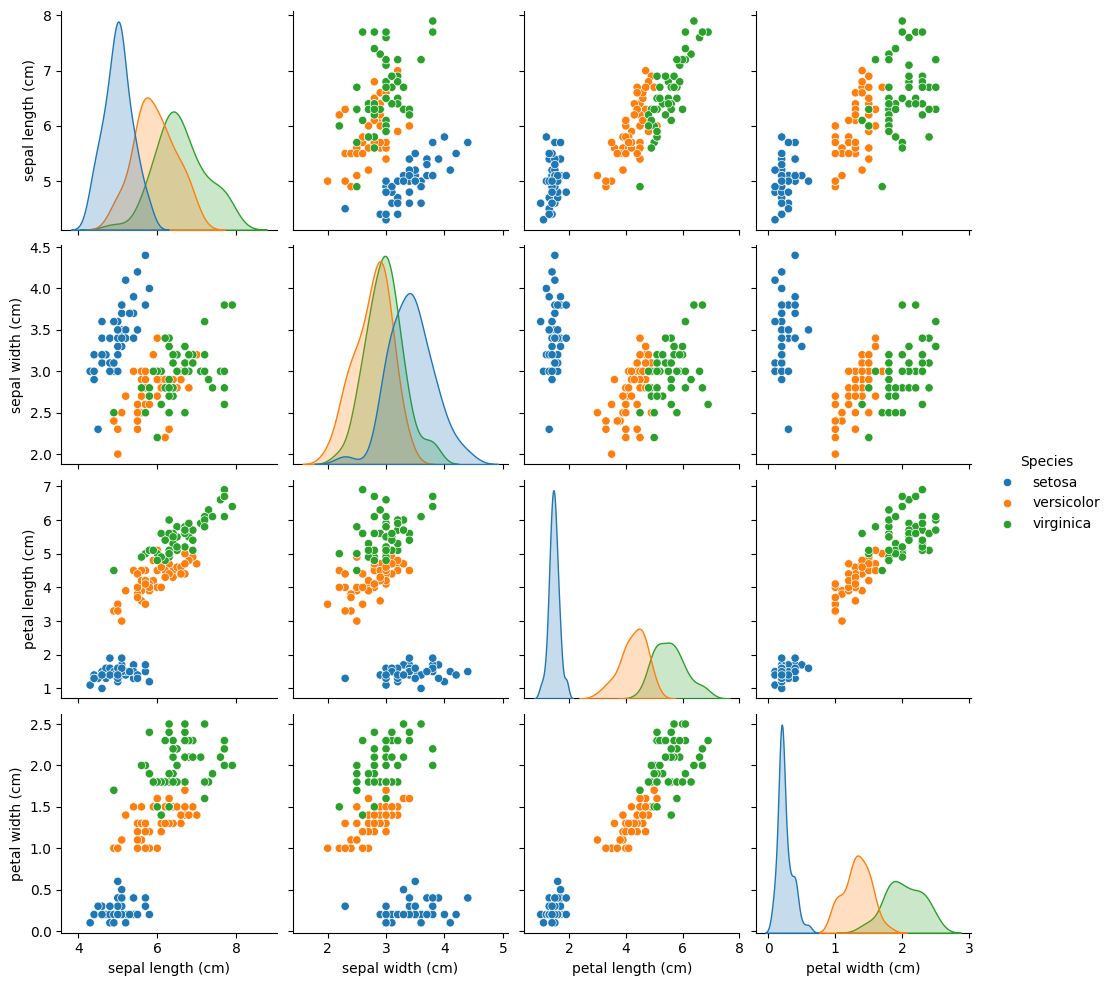

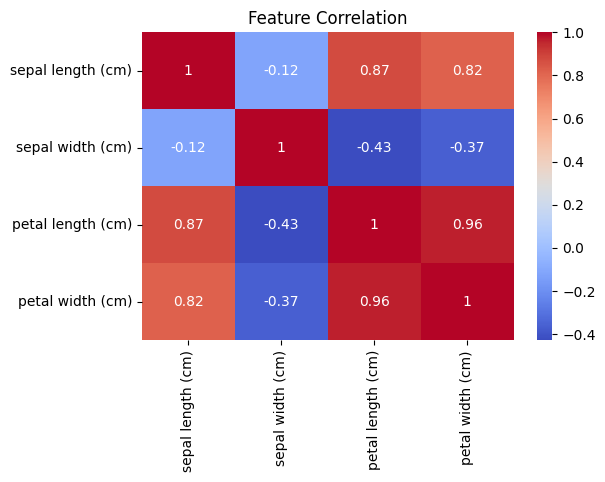

In [ ]:
# Pairplot with actual species labels
sns.pairplot(pd.DataFrame(X, columns=iris.feature_names)
             .assign(Species=iris.target_names[y]),
             hue="Species")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

## **K-Means Clustering**

**Finding Optimal K (Elbow Method)**

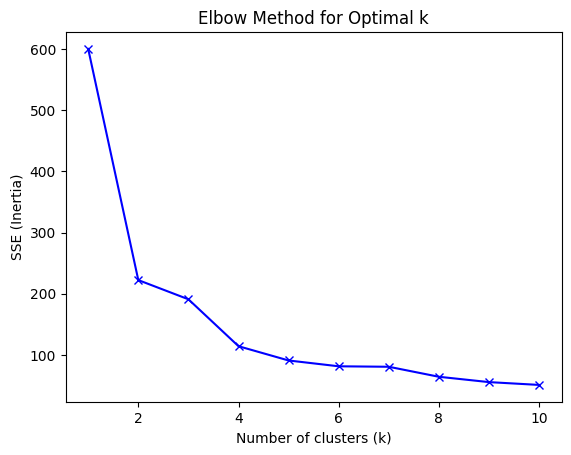

In [ ]:
sse = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Sum of squared distances

plt.plot(K, sse, 'bx-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

**Train K-Means**

Silhouette Score (KMeans): 0.4798814508199817


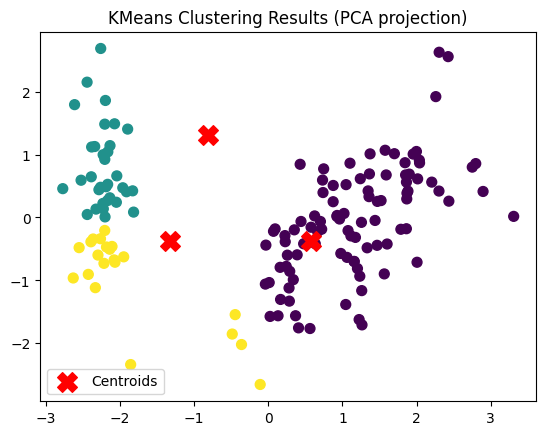

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluation with silhouette score
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
print("Silhouette Score (KMeans):", sil_kmeans)

# Visualization using PCA (2D projection)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap="viridis", s=50)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            c='red', marker='X', s=200, label="Centroids")
plt.title("KMeans Clustering Results (PCA projection)")
plt.legend()
plt.show()

## **DBSCAN**

**Train DBSCAN**

Unique labels in DBSCAN: [-1  0  1]


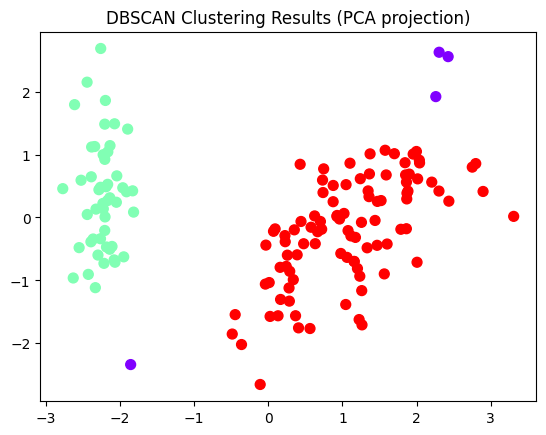

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=5)  # Parameters chosen empirically
dbscan_labels = dbscan.fit_predict(X_scaled)

# Some points may be labeled as -1 (noise)
print("Unique labels in DBSCAN:", np.unique(dbscan_labels))

# Evaluation (silhouette score requires >1 cluster and not all noise)
if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels):
    sil_dbscan = silhouette_score(X_scaled, dbscan_labels)
    print("Silhouette Score (DBSCAN):", sil_dbscan)

# Visualization
plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan_labels, cmap="rainbow", s=50)
plt.title("DBSCAN Clustering Results (PCA projection)")
plt.show()

## **Hierarchical Clustering**

**Dendrogram**

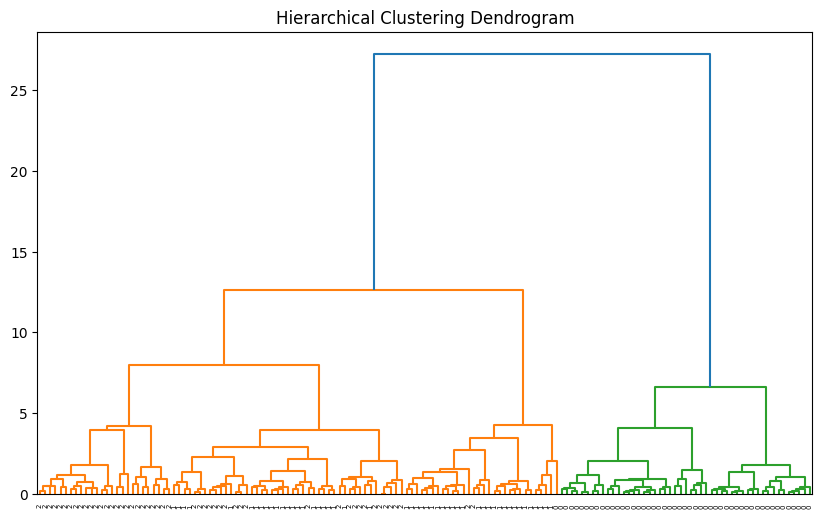

In [ ]:
# Generate linkage matrix
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', labels=y, distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

**Train Agglomerative Clustering**

Silhouette Score (Hierarchical): 0.4466890410285909


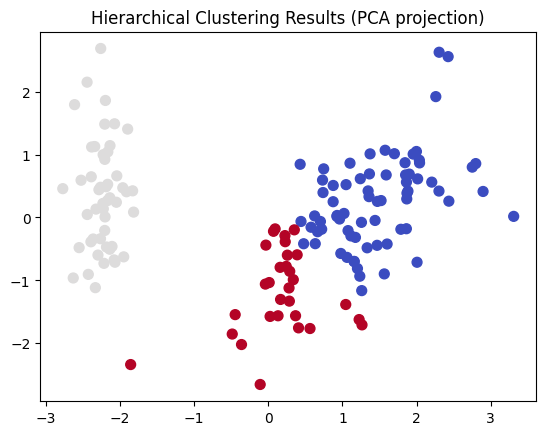

In [ ]:
hier_clust = AgglomerativeClustering(n_clusters=3, linkage="ward")
hier_labels = hier_clust.fit_predict(X_scaled)

# Evaluation
sil_hier = silhouette_score(X_scaled, hier_labels)
print("Silhouette Score (Hierarchical):", sil_hier)

# Visualization
plt.scatter(X_pca[:,0], X_pca[:,1], c=hier_labels, cmap="coolwarm", s=50)
plt.title("Hierarchical Clustering Results (PCA projection)")
plt.show()

**Compare Models**

In [ ]:
results = {
    "KMeans (k=3)": sil_kmeans,
    "DBSCAN": sil_dbscan if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels) else "N/A",
    "Hierarchical (k=3)": sil_hier
}

print("Silhouette Scores for Clustering Methods:")
for method, score in results.items():
    print(f"{method}: {score}")

Silhouette Scores for Clustering Methods:
KMeans (k=3): 0.4798814508199817
DBSCAN: N/A
Hierarchical (k=3): 0.4466890410285909


## **Results**

**KMeans (k=3): 0.48**
→ Pretty solid. It shows that the clusters are reasonably well-separated and compact. This matches intuition since Iris has 3 natural classes (Setosa, Versicolor, Virginica).

**DBSCAN: N/A**
→ DBSCAN didn’t produce valid clusters (likely it labeled many points as noise -1 or produced only 1 cluster).
👉 Reason: The Iris dataset doesn’t have density-separated clusters, so DBSCAN struggles. It works better for spatial/irregular shaped data (e.g., GPS locations, fraud anomalies).

**Hierarchical (k=3): 0.45**
→ Also reasonable, but slightly lower than KMeans. Shows that agglomerative clustering did okay, but not as crisp as KMeans for this dataset.

## **Interpretation**

For Iris, **KMeans is the best performer** because the data is fairly spherical and separable.

**DBSCAN isn’t suitable** here, but it would shine in datasets with noise or irregular cluster shapes.

**Hierarchical** is useful for visual insight (dendrogram), but its numerical score is slightly weaker.